# Mines vs Rocks

This dataset is publicly available in machine learning repositories such as: in [OpenML](https://www.openml.org) under the name "sonar" and in [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml) under the name "Connectionist Bench (Sonar, Mines vs. Rocks) Data Set." The objective is to train a model capable of distinguishing between sonar signals bounced off a metal cylinder (a proxy for a mine) and those bounced off a roughly cylindrical rock. One can consult the repositories above to learn more about the dataset. I got interested in the dataset because of the challenge of working with sparse data (208 instances in 60 dimensional space) and overcoming the curse of dimensionality.

## Step 1: Loading libraries to be used in the modeling, loading the dataset, and initial exploratory analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('numpy version: ',np.__version__)
print('pandas version: ',pd.__version__)
print('seaborn version: ',sns.__version__)

numpy version:  1.18.1
pandas version:  1.0.0
seaborn version:  0.10.0


In [2]:
#fetching the dataset from OpenML repository

from sklearn.datasets import fetch_openml
X, y = fetch_openml('sonar', return_X_y=True)

In [3]:
print('dim of X: ', X.shape)
print('dim of y: ', y.shape)

dim of X:  (208, 60)
dim of y:  (208,)


In [4]:
#forming a dataframe from predictor variables

column_names = ['var' + str(k) for k in range(1, 61)]
X = pd.DataFrame(X, columns=column_names)
X.head(7)

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0195,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103


In [5]:
#shortening the names of target variables in the obvious way

y[y == 'Rock'] = 'R'
y[y == 'Mine'] = 'M'

In [6]:
#checking to see whether we have any missing values among features: No, there are not.

X.columns[X.isnull().any()]

Index([], dtype='object')

In [7]:
#checking to see whether the response variable seems to be balanced: Yes, it seems balanced.
#also there are no missing values among the target variable.

np.unique(y, return_counts=True)

(array(['M', 'R'], dtype=object), array([111,  97], dtype=int64))

In [8]:
#this is just another way of getting the counts for the response variable.

pd.DataFrame(y).groupby(0).size()

0
M    111
R     97
dtype: int64

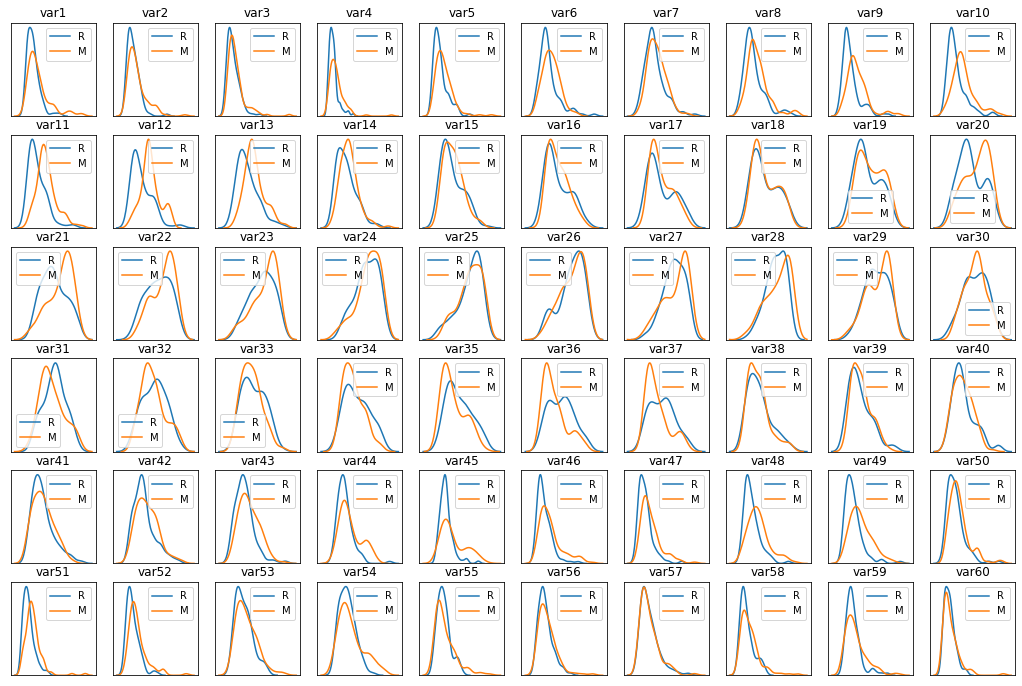

In [9]:
#distribution of each predictor variable grouped by the response variable.

plt.figure(figsize=(18,12))

for k in range(0,60):
    plt.subplot(6, 10, k+1)
    sns.kdeplot(X[(y == 'R')]['var'+str(k+1)], label='R')
    sns.kdeplot(X[(y == 'M')]['var'+str(k+1)], label='M')
    plt.title('var'+str(k+1))
    plt.xticks([])
    plt.yticks([])

plt.legend()
plt.show()

#### Observations: 

1. Distributions of the two classes (mines and rocks) for each feature seem to be very close to each other. In fact, in some cases (var18, var39, var57, var60) they seem to be virtually indistinguishable. However, there is still hope to achieve the goal since there are 60 predictor variables.

2. There are no missing values in the dataset.

3. There is no gross imbalance of the response variable, so I don't have to worry about balancing them.


## Step 2: Splitting the data into training and test sets

In [10]:
# I am setting 20% data aside for the test set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=2019)

In [11]:
#sanity check (ensuring that sizes match)

(X_train.shape[0] + X_test.shape[0] == X.shape[0],
 y_train.size + y_test.size == y.size)

(True, True)

In [12]:
#sanity check 2 (ensuring that data is split in a stratified way)

print('Train set counts:')
print(pd.DataFrame(y_train).groupby(0).size())

print('Test set counts:')
print(pd.DataFrame(y_test).groupby(0).size())

print('The ratio of the two:')
print(pd.DataFrame(y_train).groupby(0).size() / pd.DataFrame(y_test).groupby(0).size())


Train set counts:
0
M    89
R    77
dtype: int64
Test set counts:
0
M    22
R    20
dtype: int64
The ratio of the two:
0
M    4.045455
R    3.850000
dtype: float64


#### Notes:

1. I assigned 80% of the data to the training set and the remaining 20% to the test set.

2. The data is split in a stratified way to ensure proportionality of the response variable in both sets.


## Step 3: Trying Various Algorithms Straight Out of Box

According to "No Free Lunch Theorem", there is no universal algorithm which outperforms all other methods. Equivalently, if you make no assumptions about the data, then there is no reason to prefer one model over any other. Thus, I will try a good number of models on the dataset and pick top performers for further study.

I will use 'accuracy' as the metric to determine which model outperforms the others. Accuracy is the percentage of instances correctly classified. As it might be obvious to some, accuracy by itself will not be enough due to the fact that the 'cost' of misclassifying a mine as a rock is infinitely greater than the 'cost' of misclassifying a rock as a mine. As a result, we will switch to 'recall' (percentage of mines correctly classifed) later in the analysis.

### Setting the stage for algorithms that do NOT need scaling

One could have scaled the data for all algorithms without running into time/computational power issues because the dataset is fairly small. However, I chose to separate the algorithms into two classes for the sake of consistency.

In [13]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, 
                              BaggingClassifier, 
                              ExtraTreesClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                           QuadraticDiscriminantAnalysis)
from sklearn.naive_bayes import GaussianNB

models_tree = [
    ('DTC', DecisionTreeClassifier()),
    ('ETC', ExtraTreeClassifier(random_state=2019))
]

models_ensemble = [
    ('ADA', AdaBoostClassifier(random_state=2019)),
    ('Bag', BaggingClassifier(random_state=2019)),
    ('ETsC', ExtraTreesClassifier(random_state=2019)),
    ('GBC', GradientBoostingClassifier(random_state=2019)),
    ('RFC', RandomForestClassifier(random_state=2019))
]

models_da = [
    ('LDA', LinearDiscriminantAnalysis()),
    ('QDA', QuadraticDiscriminantAnalysis())
]

model_nb = [('GNB', GaussianNB())]

In [14]:
models_need_NO_scaling = models_tree + models_ensemble + models_da + model_nb

### Setting the stage for algorithms that need scaling

In [15]:
from sklearn.linear_model import (LogisticRegression, 
                                  PassiveAggressiveClassifier, 
                                  RidgeClassifier, 
                                  SGDClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models_lin = [
    ('Log_Reg', LogisticRegression()),
    ('PAC', PassiveAggressiveClassifier()),
    ('Ridge', RidgeClassifier()),
    ('SGDC', SGDClassifier())
]

model_neigh = [('KNC', KNeighborsClassifier())]

model_svm = [('SVC', SVC())]

In [16]:
models_need_scaling = models_lin + model_neigh + model_svm

### Trying algorithms that do NOT need scaling on the training set

I am using 10-fold cross validation to evaluate my models on the training set with respect to 'accuracy'.

In [17]:
from sklearn.model_selection import cross_val_score

models = models_need_NO_scaling
cv = 10
scoring = 'accuracy'

cv_results = {}

for name, model in models:
    cv_res = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [18]:
results_df = pd.DataFrame(cv_results, index=range(1, cv+1))

In [19]:
results_df.mean(axis='index').sort_values()

QDA     0.652206
GNB     0.687132
ETC     0.716912
LDA     0.723162
Bag     0.735294
RFC     0.759191
DTC     0.759926
GBC     0.795588
ADA     0.801838
ETsC    0.843382
dtype: float64

In [20]:
results_df.std(axis='index')

DTC     0.096589
ETC     0.115144
ADA     0.067267
Bag     0.098620
ETsC    0.079557
GBC     0.144963
RFC     0.079103
LDA     0.080118
QDA     0.118527
GNB     0.116589
dtype: float64

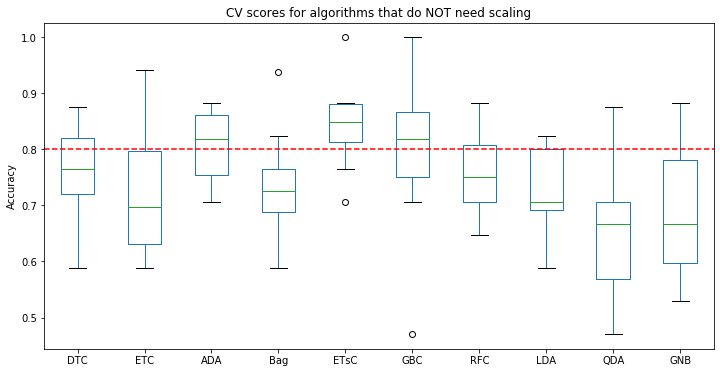

In [21]:
results_df.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for algorithms that do NOT need scaling')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Accuracy')
plt.show()

### Trying algorithms that need scaling on the training set

Again, I am using 10-fold cross validation to evaluate my models on the training set with respect to 'accuracy'.

One has to be careful about data leakage! I formed a pipeline of each model with the Standard Scaler so as to prevent underestimation of errors in cross validation.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models_sc = models_need_scaling
cv = 10
scoring = 'accuracy'

cv_results_sc = {}

for name, model in models_sc:
    model_pip = Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_sc[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [23]:
results_df_sc = pd.DataFrame(cv_results_sc, index=range(1, cv+1))

In [24]:
results_df_sc.mean(axis='index').sort_values()

PAC        0.723162
Log_Reg    0.753676
Ridge      0.759191
SGDC       0.766176
KNC        0.795956
SVC        0.801103
dtype: float64

In [25]:
results_df_sc.std(axis='index')

Log_Reg    0.111970
PAC        0.119195
Ridge      0.072734
SGDC       0.107203
KNC        0.109560
SVC        0.070664
dtype: float64

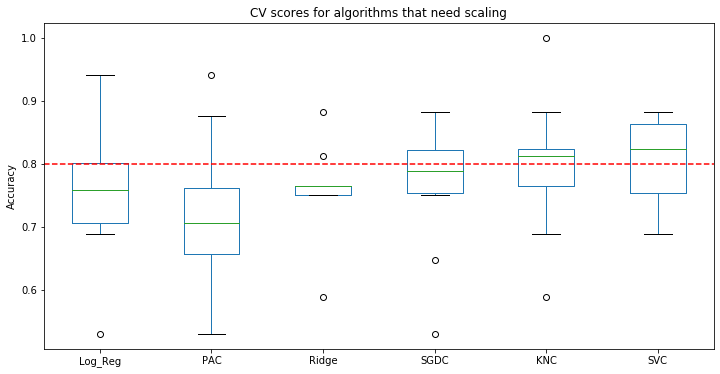

In [26]:
results_df_sc.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for algorithms that need scaling')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Accuracy')
plt.show()

### Comparison of all out-of-box algorithms

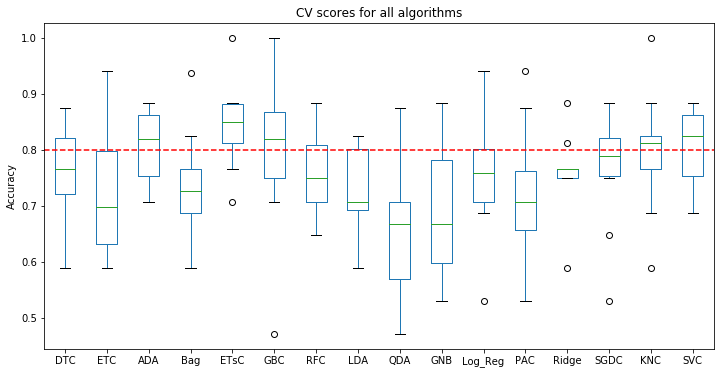

In [27]:
results = pd.concat([results_df, results_df_sc], axis='columns')

results.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for all algorithms')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Accuracy')
plt.show()

#### Results:

The following algorithms deserve further study:
1. SVC -- Support Vector Classifier
2. KNC -- K-Neighbors Classifier
3. ETsC -- Extra Trees Classifier
4. GBC -- Gradient Boosting Classifier
5. ADA -- Ada Boost Classifier

Here one sees that there are many models with very high variance, i.e. ETC, DTC, and others which is a direct result of the smallness of sample size.

## Step 4: Fine Tuning of Promising Algorithms

I will fine-tune (find optimal hyperparameters) for the promising algorithms using 10-fold cross validation with respect to 'accuracy'.

In [28]:
from sklearn.model_selection import GridSearchCV

### KNC -- K-Neighbors Classifier

I am somewhat surprised to see that K-Neighbors Classifier turned out be one of the better performing algorithms on this data set. The surprising part is that KNC typically performs well on datasets with few features (residing in a low dimensional space) whereas our dataset is quite the opposite.

In [29]:
neighbors = list(range(1, 21))  #default=5, bias decreases as it decreases
par_grid_KNC = dict(KNC__n_neighbors=neighbors)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('KNC', KNeighborsClassifier())
])

grid_KNC = GridSearchCV(estimator=model, param_grid=par_grid_KNC, cv=10, 
                        verbose=2, n_jobs=-1, scoring='accuracy')
grid_result_KNC = grid_KNC.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [30]:
grid_result_KNC.best_params_

{'KNC__n_neighbors': 1}

In [31]:
grid_result_KNC.best_score_

0.8257352941176471

In [32]:
pd.DataFrame(grid_result_KNC.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
0,{'KNC__n_neighbors': 1},0.825735,0.060527,1
2,{'KNC__n_neighbors': 3},0.820588,0.085841,2
1,{'KNC__n_neighbors': 2},0.820221,0.077946,3
4,{'KNC__n_neighbors': 5},0.795956,0.103938,4
6,{'KNC__n_neighbors': 7},0.777941,0.124699,5
3,{'KNC__n_neighbors': 4},0.765441,0.100990,6
5,{'KNC__n_neighbors': 6},0.741912,0.125505,7


#### The best estimator is with n_neighbors=1, 2, or 3. From these I will pick the one with lowest variance, i.e. n_neighbors=1.

### SVC -- Support Vector Classifier

In [33]:
C_val = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 
         3.0, 5.0, 10.0]   #default=1, bias increases as it decreases
kernel =  ['linear', 'rbf', 'poly', 'sigmoid'] #default='rbf'
degree = [2, 3, 4, 5] #default=3

par_grid_svc = dict(svc__C=C_val, svc__kernel=kernel, svc__degree=degree)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

grid_svc = GridSearchCV(estimator=model, param_grid=par_grid_svc, cv=10, 
                        verbose=2, n_jobs=-1, scoring='accuracy')
grid_result_svc = grid_svc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Fitting 10 folds for each of 224 candidates, totalling 2240 fits


[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed:    2.8s finished


In [34]:
grid_result_svc.best_params_

{'svc__C': 5.0, 'svc__degree': 2, 'svc__kernel': 'rbf'}

In [35]:
grid_result_svc.best_score_

0.8735294117647058

In [36]:
pd.DataFrame(grid_result_svc.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(10)

,params,mean_test_score,std_test_score,rank_test_score
201,"{'svc__C': 5.0, 'svc__degree': 4, 'svc__kernel...",0.873529,0.077489,1
193,"{'svc__C': 5.0, 'svc__degree': 2, 'svc__kernel...",0.873529,0.077489,1
205,"{'svc__C': 5.0, 'svc__degree': 5, 'svc__kernel...",0.873529,0.077489,1
197,"{'svc__C': 5.0, 'svc__degree': 3, 'svc__kernel...",0.873529,0.077489,1
213,"{'svc__C': 10.0, 'svc__degree': 3, 'svc__kerne...",0.873529,0.067974,1
209,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__kerne...",0.873529,0.067974,1
221,"{'svc__C': 10.0, 'svc__degree': 5, 'svc__kerne...",0.873529,0.067974,1
217,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__kerne...",0.873529,0.067974,1
189,"{'svc__C': 3.0, 'svc__degree': 5, 'svc__kernel...",0.861397,0.054059,9
181,"{'svc__C': 3.0, 'svc__degree': 3, 'svc__kernel...",0.861397,0.054059,9


#### There are several models tied to the first spot. I will pick the one with lowest variance, i.e. C=10.0 and kernel='rbf

## ETsC -- Extra Trees Classifier

In [37]:
n_estimators = [10, 25, 50, 75, 100, 115, 125, 135, 150]   #default=10, bias increases as it decreases
max_depth =  [1, 2, 3, 5, 7, 10, 13, 15, 17, 19, 21] 

par_grid_X_tree = dict(n_estimators=n_estimators, max_depth=max_depth)

model = ExtraTreesClassifier(random_state=2019)

grid_X_tree = GridSearchCV(estimator=model, param_grid=par_grid_X_tree, cv=10, 
                        verbose=2, n_jobs=-1, scoring='accuracy')
grid_result_X_tree = grid_X_tree.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   20.2s finished


In [38]:
grid_result_X_tree.best_params_

{'max_depth': 13, 'n_estimators': 125}

In [39]:
grid_result_X_tree.best_score_

0.8555147058823529

In [40]:
pd.DataFrame(grid_result_X_tree.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
62,"{'max_depth': 13, 'n_estimators': 150}",0.855515,0.070528,1
60,"{'max_depth': 13, 'n_estimators': 125}",0.855515,0.079739,1
86,"{'max_depth': 19, 'n_estimators': 115}",0.855515,0.075274,1
95,"{'max_depth': 21, 'n_estimators': 115}",0.855515,0.075274,1
43,"{'max_depth': 7, 'n_estimators': 135}",0.855147,0.071350,5
65,"{'max_depth': 15, 'n_estimators': 50}",0.854044,0.083141,6
96,"{'max_depth': 21, 'n_estimators': 125}",0.849632,0.075246,7


#### The best estimator is one with max_depth=13, n_estimators=25.

## GBC -- Gradient Boosting Classifier

In [41]:
n_estimators = list(range(95, 151, 5))   #default=100, bias increases as it decreases
max_depth = [1, 2, 3, 4, 5] #default=3
learning_rate = [0.2, 0.1, 0.05, 0.01] #default=0.1

par_grid_gb = dict(n_estimators=n_estimators, max_depth=max_depth, 
                   learning_rate=learning_rate)

model = GradientBoostingClassifier(random_state=2019)

grid_gb = GridSearchCV(estimator=model, param_grid=par_grid_gb, cv=10, 
                        verbose=2, n_jobs=-1, scoring='accuracy')
grid_result_gb = grid_gb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1821 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2266 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  1.7min finished


In [42]:
# it seems sklearn doesn't look at variance when picking the best estimator when there are several tied to the first place

grid_result_gb.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 115}

In [43]:
grid_result_gb.best_score_

0.83125

In [44]:
pd.DataFrame(grid_result_gb.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(10)

,params,mean_test_score,std_test_score,rank_test_score
80,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.831250,0.095240,1
82,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.831250,0.095240,1
21,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.831250,0.091535,1
20,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.831250,0.091535,1
16,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.831250,0.091535,1
13,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.825368,0.093707,6
81,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.825368,0.097329,6
141,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.825368,0.097329,6
17,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.825368,0.093707,6
79,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.825368,0.093707,6


In [45]:
pd.DataFrame(grid_result_gb.cv_results_).loc[140, ['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']][0]

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 135}

#### The best estimator seems to be with learning_rate=0.05, max_depth=2, and n_estimators=135. There are 9 estimators tied to the first place and I picked the one with smallest variance

## ADA -- Ada Boost Classifier

In [46]:
n_estimators = list(range(15, 151, 5))   #default=50, bias increases as it decreases
learning_rate = [1.0, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01] #default=1

par_grid_ada = dict(n_estimators=n_estimators, learning_rate=learning_rate)

model = AdaBoostClassifier(random_state=2019)

grid_ada = GridSearchCV(estimator=model, param_grid=par_grid_ada, cv=10, 
                        verbose=2, n_jobs=-1, scoring='accuracy')
grid_result_ada = grid_ada.fit(X_train, y_train)

Fitting 10 folds for each of 196 candidates, totalling 1960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 485 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1133 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 1578 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1960 out of 1960 | elapsed:  1.4min finished


In [47]:
grid_result_ada.best_params_

{'learning_rate': 0.25, 'n_estimators': 40}

In [48]:
grid_result_ada.best_score_

0.84375

In [49]:
pd.DataFrame(grid_result_ada.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
33,"{'learning_rate': 0.25, 'n_estimators': 40}",0.843750,0.089062,1
22,"{'learning_rate': 1.0, 'n_estimators': 125}",0.832353,0.087500,2
24,"{'learning_rate': 1.0, 'n_estimators': 135}",0.832353,0.102100,2
32,"{'learning_rate': 0.25, 'n_estimators': 35}",0.831985,0.095135,4
31,"{'learning_rate': 0.25, 'n_estimators': 30}",0.831618,0.087107,5
23,"{'learning_rate': 1.0, 'n_estimators': 130}",0.826471,0.097240,6
21,"{'learning_rate': 1.0, 'n_estimators': 120}",0.826471,0.097240,6


#### The best estimator seems to be with learning_rate=0.25 and n_estimators=40.

## Step 5: Evaluation of the Tuned Models on the Test Set

In [50]:
from sklearn.metrics import accuracy_score, recall_score

#### KNC -- K-Neighbors Classifier with n_neighbors=1

In [51]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_sc, y_train)
preds = knn.predict(X_test_sc)
print('KNC accuracy: ', accuracy_score(y_test, preds))
print('KNC recall: ', recall_score(y_test, preds, pos_label='M'))

KNC accuracy:  0.8571428571428571
KNC recall:  0.9090909090909091


This is truly weird! The accuracy on the test set is about 4% higher than the 10-fold cross validation accuracy on the training set. This is indicative of the high variance of the estimator coupled with small sample size.

#### SVC -- Support Vector Classifier with C=10.0 and kernel='rbf'

In [52]:
svc = SVC(C=10.0, kernel='rbf')
svc.fit(X_train_sc, y_train)
preds = svc.predict(X_test_sc)
print('SVC accuracy: ', accuracy_score(y_test, preds))
print('SVC recall: ', recall_score(y_test, preds, pos_label='M'))

SVC accuracy:  0.9523809523809523
SVC recall:  0.9545454545454546


Again, this is truly weird! The accuracy on the test set is about 8% higher than the 10-fold cross validation accuracy on the training set. This is indicative of the high variance of the estimator coupled with small sample size.

#### ETsC -- Extra Trees Classifier with max_depth=13 and n_estimators=25.

In [53]:
x_tree = ExtraTreesClassifier(max_depth=13, n_estimators=25, random_state=2019)
x_tree.fit(X_train, y_train)
preds = x_tree.predict(X_test)
print('ETsC accuracy: ', accuracy_score(y_test, preds))
print('ETsC recall: ', recall_score(y_test, preds, pos_label='M'))

ETsC accuracy:  0.8809523809523809
ETsC recall:  1.0


We might have a winner here! Even though the accuracy of this estimator is lower than three others, it has perfect recall.

#### GBC -- Gradient Boosting Classifier with learning_rate=0.05, max_depth=2, and n_estimators=135

In [54]:
grad_boost = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=115, random_state=2019)
grad_boost.fit(X_train, y_train)
preds = grad_boost.predict(X_test)
print('GBC accuracy: ', accuracy_score(y_test, preds))
print('GBC recall: ', recall_score(y_test, preds, pos_label='M'))

GBC accuracy:  0.9047619047619048
GBC recall:  0.9090909090909091


Again, this is truly weird! The accuracy on the test set is about 8% higher than the 10-fold cross validation accuracy on the training set. This is indicative of the high variance of the estimator coupled with small sample size.

#### ADA -- Ada Boost Classifier with learning_rate=0.25 and n_estimators=40

In [55]:
ada_boost = AdaBoostClassifier(learning_rate=0.25, n_estimators=40, random_state=2019)
ada_boost.fit(X_train, y_train)
preds = ada_boost.predict(X_test)
print('ADA accuracy: ', accuracy_score(y_test, preds))
print('ADA recall: ', recall_score(y_test, preds, pos_label='M'))

ADA accuracy:  0.8095238095238095
ADA recall:  0.8636363636363636


## Step 6: Evaluation of the Extra Trees Classifier

In [56]:
print('ETsC accuracy on the training set: ', accuracy_score(y_train, x_tree.predict(X_train)))
print('ETsC recall on the training set: ', recall_score(y_train, x_tree.predict(X_train), pos_label='M'))

ETsC accuracy on the training set:  1.0
ETsC recall on the training set:  1.0


In [57]:
print('ETsC accuracy on the test set: ', accuracy_score(y_test, x_tree.predict(X_test)))
print('ETsC recall on the test set: ', recall_score(y_test, x_tree.predict(X_test), pos_label='M'))

ETsC accuracy on the test set:  0.8809523809523809
ETsC recall on the test set:  1.0


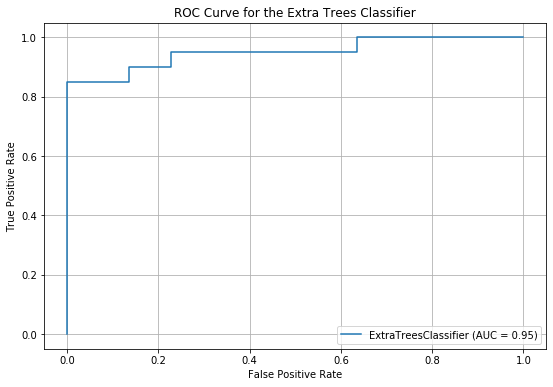

In [58]:
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(x_tree, X_test, y_test)
disp.figure_.set_size_inches(9, 6)
plt.title('ROC Curve for the Extra Trees Classifier')
plt.grid()


In [59]:
print('Area under the ROC Curve for the Extra Trees Classifier: ', disp.roc_auc)

Area under the ROC Curve for the Extra Trees Classifier:  0.95


## Step 7: How reliable is the Extra Trees Classifier for this dataset?

It seems to me that I got somehow lucky by choosing random_state=2019. Now, I will vary the random_state for 200 times and average the results in order to have a better sense of the reliability of the model.

In [60]:
acc_results_ETsC = []
rec_results_ETsC = []

for r in range(1970, 2170):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=r)
    x_tree = ExtraTreesClassifier(max_depth=13, n_estimators=25, random_state=r)
    x_tree.fit(X_train, y_train)
    preds = x_tree.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_results_ETsC.append(acc)
    rec = recall_score(y_test, preds, pos_label='M')
    rec_results_ETsC.append(rec)

In [61]:
print('average accuracy of ETsC: ', np.mean(acc_results_ETsC))
print('std of accuracy ETsC: ', np.std(acc_results_ETsC))

average accuracy of ETsC:  0.8380952380952381
std of accuracy ETsC:  0.05961897155023292


In [62]:
print('average recall of ETsC: ', np.mean(rec_results_ETsC))
print('std of recall of ETsC: ', np.std(rec_results_ETsC))

average recall of ETsC:  0.8906818181818181
std of recall of ETsC:  0.07400825004268217


This result confirms that I somehow got lucky by choosing 2019 as the random_state. The result above shows that the average accuracy and recall of the model is lower.

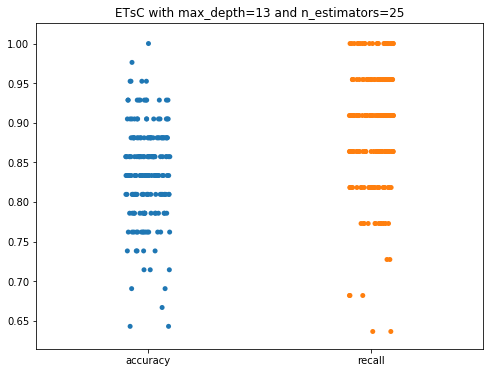

In [63]:
d = pd.DataFrame({'accuracy':acc_results_ETsC, 'recall':rec_results_ETsC})
plt.figure(figsize=(8,6))
sns.stripplot(data=d)
plt.title('ETsC with max_depth=13 and n_estimators=25')
plt.show()

## Step 8: Can SVC be better than ETsC on average?

Now I will use the same procedure to answer the question.

In [64]:
acc_results_SVC = []
rec_results_SVC = []

for r in range(1970, 2170):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=r)
    model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10.0))])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_results_SVC.append(acc)
    rec = recall_score(y_test, preds, pos_label='M')
    rec_results_SVC.append(rec)

In [65]:
print('average accuracy of SVC: ', np.mean(acc_results_SVC))
print('std of accuracy SVC: ', np.std(acc_results_SVC))

average accuracy of SVC:  0.876547619047619
std of accuracy SVC:  0.04708495120933532


In [66]:
print('average recall of SVC: ', np.mean(rec_results_SVC))
print('std of recall of SVC: ', np.std(rec_results_SVC))

average recall of SVC:  0.9247727272727272
std of recall of SVC:  0.05831616236849292


And the answer is "YES!"

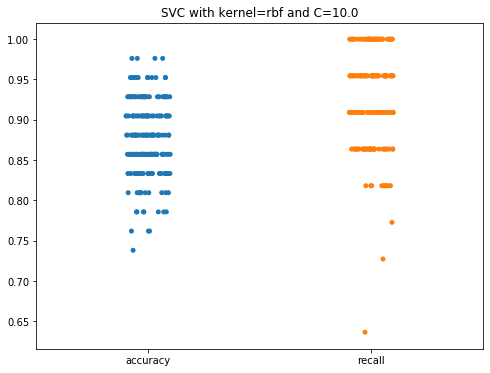

In [67]:
d = pd.DataFrame({'accuracy':acc_results_SVC, 'recall':rec_results_SVC})
plt.figure(figsize=(8,6))
sns.stripplot(data=d)
plt.title('SVC with kernel=''rbf'' and C=10.0')
plt.show()

## Step 9: What about KNC?

In [68]:
acc_results_KNC = []
rec_results_KNC = []

for r in range(1970, 2170):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=r)
    model = Pipeline([
    ('scaler', StandardScaler()),
    ('knc', KNeighborsClassifier(n_neighbors=1))])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_results_KNC.append(acc)
    rec = recall_score(y_test, preds, pos_label='M')
    rec_results_KNC.append(rec)

In [69]:
print('average accuracy of KNC: ', np.mean(acc_results_KNC))
print('std of accuracy KNC: ', np.std(acc_results_KNC))

average accuracy of KNC:  0.8586904761904762
std of accuracy KNC:  0.049606015791646564


In [70]:
print('average recall of KNC: ', np.mean(rec_results_KNC))
print('std of recall of KNC: ', np.std(rec_results_KNC))

average recall of KNC:  0.9011363636363637
std of recall of KNC:  0.05899248796553368


Better than ETsC, but not as good as SVC!

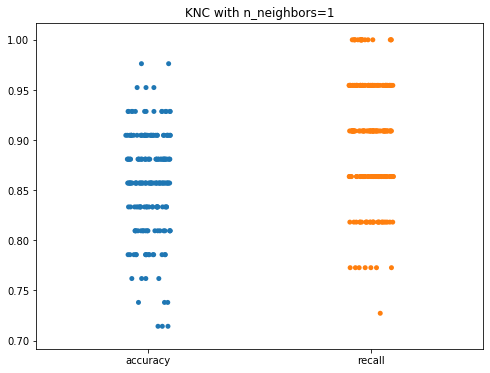

In [71]:
d = pd.DataFrame({'accuracy':acc_results_KNC, 'recall':rec_results_KNC})
plt.figure(figsize=(8,6))
sns.stripplot(data=d)
plt.title('KNC with n_neighbors=1')
plt.show()

## Step 10: What about GBC and ADA?

In [72]:
acc_results_GBC = []
rec_results_GBC = []

for r in range(1970, 2170):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=r)
    model = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=115, random_state=r)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_results_GBC.append(acc)
    rec = recall_score(y_test, preds, pos_label='M')
    rec_results_GBC.append(rec)

In [73]:
print('average accuracy of GBC: ', np.mean(acc_results_GBC))
print('std of accuracy GBC: ', np.std(acc_results_GBC))

average accuracy of GBC:  0.8171428571428572
std of accuracy GBC:  0.060831353056949415


In [74]:
print('average recall of GBC: ', np.mean(rec_results_GBC))
print('std of recall of GBC: ', np.std(rec_results_GBC))

average recall of GBC:  0.86
std of recall of GBC:  0.07942978603201012


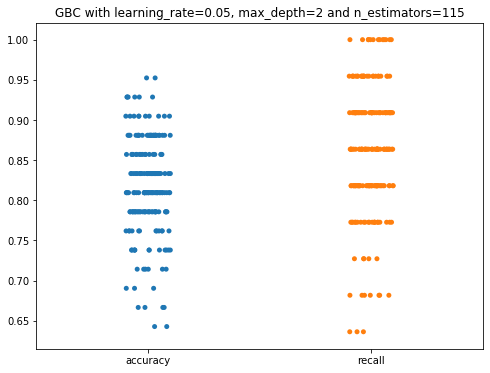

In [75]:
d = pd.DataFrame({'accuracy':acc_results_GBC, 'recall':rec_results_GBC})
plt.figure(figsize=(8,6))
sns.stripplot(data=d)
plt.title('GBC with learning_rate=0.05, max_depth=2 and n_estimators=115')
plt.show()

In [76]:
acc_results_ADA = []
rec_results_ADA = []

for r in range(1970, 2170):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=r)
    model = AdaBoostClassifier(learning_rate=0.25, n_estimators=40, random_state=r)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_results_ADA.append(acc)
    rec = recall_score(y_test, preds, pos_label='M')
    rec_results_ADA.append(rec)

In [77]:
print('average accuracy of ADA: ', np.mean(acc_results_ADA))
print('std of accuracy ADA: ', np.std(acc_results_ADA))

average accuracy of ADA:  0.7867857142857143
std of accuracy ADA:  0.06526144437912004


In [78]:
print('average recall of ADA: ', np.mean(rec_results_ADA))
print('std of recall of ADA: ', np.std(rec_results_ADA))

average recall of ADA:  0.8231818181818181
std of recall of ADA:  0.08128487808294159


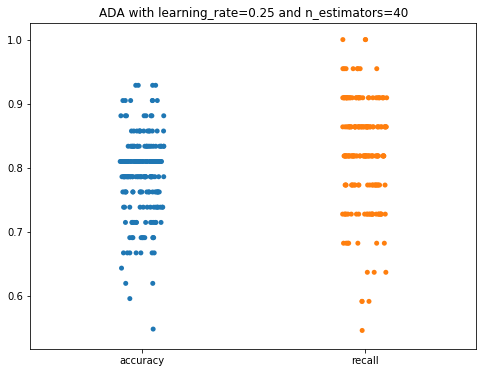

In [79]:
d = pd.DataFrame({'accuracy':acc_results_ADA, 'recall':rec_results_ADA})
plt.figure(figsize=(8,6))
sns.stripplot(data=d)
plt.title('ADA with learning_rate=0.25 and n_estimators=40')
plt.show()

## Conclusion

If I am forced to pick a model, I would pick SVC since it outperformed all other models on average in both metrics. The results are far from acceptable for such a sensitive goal though!
The moral is that all models have high variance on small datasets and one should not settle for a model that might outperform others due to pure luck.

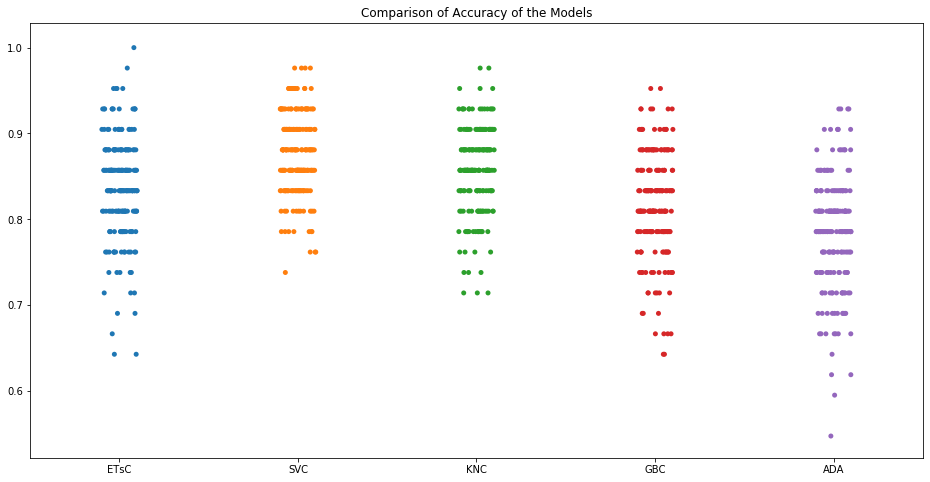

In [80]:
acc = pd.DataFrame({'ETsC': acc_results_ETsC, 'SVC': acc_results_SVC, 'KNC': acc_results_KNC, 
                    'GBC': acc_results_GBC, 'ADA': acc_results_ADA})
plt.figure(figsize=(16,8))
sns.stripplot(data=acc)
plt.title('Comparison of Accuracy of the Models')
plt.show()

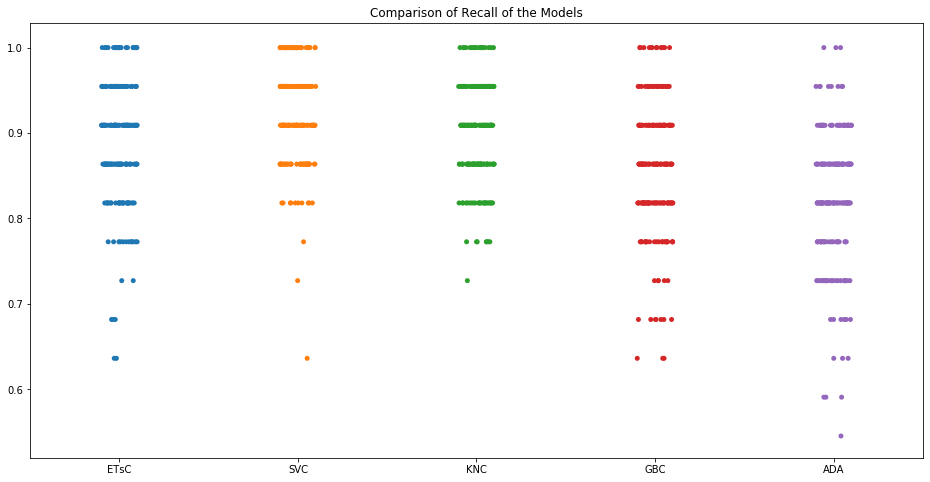

In [81]:
rec = pd.DataFrame({'ETsC': rec_results_ETsC, 'SVC': rec_results_SVC, 'KNC': rec_results_KNC, 
                    'GBC': rec_results_GBC, 'ADA': rec_results_ADA})
plt.figure(figsize=(16,8))
sns.stripplot(data=rec)
plt.title('Comparison of Recall of the Models')
plt.show()